In [1]:
#6->3->6

## Imports

In [2]:
import random

import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [3]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e3_enhance
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Get Data

In [4]:
input_data = get_dataset(img_width=8, img_height=8, train=True)
print("Original data set size:", len(input_data))

# Select only the pictures with numbers 0 or 1. (jus to compare with literature)
filtered_data = [image for image in input_data if image[1] in [0, 1]]
input_data = filtered_data
print("Final data set szize:", len(input_data))

Original data set size: 60000
Final data set szize: 12665


## Training node

In [5]:
shots = 2500
nr_trash=3
nr_latent=3
nr_ent=0
nr_layers = 4

spec = QubitsArrangement(nr_trash, nr_latent, nr_swap=1, nr_ent=nr_ent, nr_aux=nr_trash+nr_ent)
print("Qubits:", spec.qubits)

#set up the device 
dev = qml.device("default.qubit", wires=spec.num_qubits)

Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [6]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    setAB_amplitude(spec, init_params)
    setAux(spec, reinit_state)
    setEnt(spec, inputs=[1 / np.sqrt(2), 0, 0, 1 / np.sqrt(2)])

    #encoder 
    for params in encoder_params:
        e3_enhance(params, x, spec)

    #swap test 
    swap_t(spec)

    return [qml.probs(i) for i in spec.swap_qubits]

## Training parameters 

In [7]:
epochs = 2000
learning_rate = 0.0003
batch_size = 5
num_samples = 20

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [8]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [9]:
def cost(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0][0],
                                          encoder_params=encoder_params,
                                          reinit_state=reinit_state, x=x[1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [10]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(spec.aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0][0],
                                          encoder_params=encoder_params,
                                          reinit_state=reinit_state, x=x[1])[0]
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [11]:
def iterate_batches(X, batch_size):
    X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in X]
    X2 = []
    for i in range(len(X1)):
        X2.append([X1[1], X[i][1]])
    X = X2
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [12]:
training_data = [input_data[i] for i in range(num_samples)]
test_data = [input_data[i] for i in range(num_samples,num_samples+num_samples)]

In [13]:
X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in training_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_training = X2

X1 = [torch.reshape(x[0], (1, 2 ** (len(spec.latent_qubits) + len(spec.trash_qubits)))) for x in test_data]
X2 = []
for i in range(len(X1)):
    X2.append([X1[1], training_data[i][1]])
X_tes = X2

In [14]:
# initialize random encoder parameters

nr_encod_qubits = len(spec.trash_qubits) + len(spec.latent_qubits)
nr_par_encoder = nr_layers * 2 * nr_encod_qubits + 2 * len(spec.trash_qubits)
encoder_params = np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)

###  training

In [15]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.961302736840627 | Fidelity:0.5098773377496546
Test-Epoch:0 | Loss:1.96124653692839 | Fidelity:0.5099189443497849
Epoch:5 | Loss:1.9592610815720064 | Fidelity:0.5104074630191302
Test-Epoch:5 | Loss:1.9603129967737989 | Fidelity:0.5101637744057934
Epoch:10 | Loss:1.9569510160069146 | Fidelity:0.5110081902717762
Test-Epoch:10 | Loss:1.959590653951037 | Fidelity:0.51035431836644
Epoch:15 | Loss:1.954129557325445 | Fidelity:0.5117436715163843
Test-Epoch:15 | Loss:1.9586541133234552 | Fidelity:0.5105998939528993
Epoch:20 | Loss:1.9505986817660912 | Fidelity:0.5126674419779268
Test-Epoch:20 | Loss:1.95718574272601 | Fidelity:0.5109831504828762
Epoch:25 | Loss:1.946426304836648 | Fidelity:0.5137642365673059
Test-Epoch:25 | Loss:1.955043928649684 | Fidelity:0.5115419504760341
Epoch:30 | Loss:1.9412282004242005 | Fidelity:0.5151381422832558
Test-Epoch:30 | Loss:1.9521099189670625 | Fidelity:0.5123073482530213
Epoch:35 | Loss:1.9352775920069345 | Fidelity:0.5167218870251967
Test-

Test-Epoch:300 | Loss:1.5513961612120253 | Fidelity:0.6448064211298783
Epoch:305 | Loss:1.5277364577632357 | Fidelity:0.6550793016456076
Test-Epoch:305 | Loss:1.5465272335623346 | Fidelity:0.6468384939573795
Epoch:310 | Loss:1.523661431946493 | Fidelity:0.6568262150027396
Test-Epoch:310 | Loss:1.5419326408117775 | Fidelity:0.6487716833537702
Epoch:315 | Loss:1.5197665302476964 | Fidelity:0.6585029172309194
Test-Epoch:315 | Loss:1.537569452095057 | Fidelity:0.650616849475113
Epoch:320 | Loss:1.5160568858740497 | Fidelity:0.6601117528546683
Test-Epoch:320 | Loss:1.5334492883093973 | Fidelity:0.652370964910048
Epoch:325 | Loss:1.5125072747813249 | Fidelity:0.6616582675386405
Test-Epoch:325 | Loss:1.5295364326191305 | Fidelity:0.6540450928032927
Epoch:330 | Loss:1.5090897390882385 | Fidelity:0.6631487980984476
Test-Epoch:330 | Loss:1.5257903180198185 | Fidelity:0.6556522615334176
Epoch:335 | Loss:1.5058432525230538 | Fidelity:0.6645797397825607
Test-Epoch:335 | Loss:1.5222760543887883 | Fi

Epoch:605 | Loss:1.4058466007247277 | Fidelity:0.711537285458707
Test-Epoch:605 | Loss:1.430113940435233 | Fidelity:0.699343186008409
Epoch:610 | Loss:1.404725094691123 | Fidelity:0.7120996427161508
Test-Epoch:610 | Loss:1.4292306127919692 | Fidelity:0.699771728650926
Epoch:615 | Loss:1.4036277060950177 | Fidelity:0.7126525357521565
Test-Epoch:615 | Loss:1.4283693690326873 | Fidelity:0.7001909935488388
Epoch:620 | Loss:1.4025482090923378 | Fidelity:0.7131971915825113
Test-Epoch:620 | Loss:1.4275238415348777 | Fidelity:0.7006030840028481
Epoch:625 | Loss:1.4014863846844283 | Fidelity:0.7137336133245915
Test-Epoch:625 | Loss:1.4266938972459453 | Fidelity:0.7010080046078186
Epoch:630 | Loss:1.4004281466587676 | Fidelity:0.7142650925758967
Test-Epoch:630 | Loss:1.4258713634750904 | Fidelity:0.7014077849464887
Epoch:635 | Loss:1.399388053624001 | Fidelity:0.7147883150440901
Test-Epoch:635 | Loss:1.4250669474133753 | Fidelity:0.7017992688108239
Epoch:640 | Loss:1.3983791504887806 | Fidelity:

Test-Epoch:905 | Loss:1.3978590879754986 | Fidelity:0.7153986614725983
Epoch:910 | Loss:1.363895909942835 | Fidelity:0.7332707162575278
Test-Epoch:910 | Loss:1.3975490470737424 | Fidelity:0.7155566879956703
Epoch:915 | Loss:1.363505822358987 | Fidelity:0.733478815275119
Test-Epoch:915 | Loss:1.3972416075363618 | Fidelity:0.7157134878012293
Epoch:920 | Loss:1.3631253800464884 | Fidelity:0.7336822956015877
Test-Epoch:920 | Loss:1.3969345950719894 | Fidelity:0.7158703129297252
Epoch:925 | Loss:1.3627485332289888 | Fidelity:0.7338838424358973
Test-Epoch:925 | Loss:1.3966312069838436 | Fidelity:0.7160253086958102
Epoch:930 | Loss:1.3623799393970324 | Fidelity:0.7340813649569589
Test-Epoch:930 | Loss:1.3963289596831492 | Fidelity:0.716179905255932
Epoch:935 | Loss:1.3620077185066244 | Fidelity:0.7342802551675907
Test-Epoch:935 | Loss:1.396033527180839 | Fidelity:0.716330815031429
Epoch:940 | Loss:1.3616405407620547 | Fidelity:0.7344766411711989
Test-Epoch:940 | Loss:1.395740187427013 | Fidel

Test-Epoch:1205 | Loss:1.3766574983100288 | Fidelity:0.7263971338713588
Epoch:1210 | Loss:1.3421376809793508 | Fidelity:0.7450928697046442
Test-Epoch:1210 | Loss:1.37599978095797 | Fidelity:0.7267443663831378
Epoch:1215 | Loss:1.34162856570421 | Fidelity:0.7453746096286277
Test-Epoch:1215 | Loss:1.3752746350458298 | Fidelity:0.7271276034207901
Epoch:1220 | Loss:1.3411168279918364 | Fidelity:0.7456584087218809
Test-Epoch:1220 | Loss:1.3745529471430582 | Fidelity:0.7275093945107056
Epoch:1225 | Loss:1.340592218914424 | Fidelity:0.7459496797270994
Test-Epoch:1225 | Loss:1.37379892635224 | Fidelity:0.7279087063025949
Epoch:1230 | Loss:1.3400512532531288 | Fidelity:0.7462503216152739
Test-Epoch:1230 | Loss:1.3730004964983378 | Fidelity:0.7283320021307416
Epoch:1235 | Loss:1.339480136049878 | Fidelity:0.7465676997153824
Test-Epoch:1235 | Loss:1.3721269802900864 | Fidelity:0.7287956904044934
Epoch:1240 | Loss:1.3388935170614393 | Fidelity:0.7468941895192229
Test-Epoch:1240 | Loss:1.3712243041

Epoch:1505 | Loss:1.2147342090612354 | Fidelity:0.8246479417262214
Test-Epoch:1505 | Loss:1.2301745638627608 | Fidelity:0.8143965252152701
Epoch:1510 | Loss:1.213244029901134 | Fidelity:0.8256650699328809
Test-Epoch:1510 | Loss:1.2289869377246796 | Fidelity:0.8151653020038223
Epoch:1515 | Loss:1.2118136522105718 | Fidelity:0.8266293736523919
Test-Epoch:1515 | Loss:1.2278141966346359 | Fidelity:0.8159148126981807
Epoch:1520 | Loss:1.210437624732285 | Fidelity:0.8275675526664585
Test-Epoch:1520 | Loss:1.2267131531813682 | Fidelity:0.8166262607576102
Epoch:1525 | Loss:1.2091277869594705 | Fidelity:0.8284737406958269
Test-Epoch:1525 | Loss:1.2256938929496557 | Fidelity:0.8172943632486047
Epoch:1530 | Loss:1.2078623246259719 | Fidelity:0.8293406355735768
Test-Epoch:1530 | Loss:1.224686500179763 | Fidelity:0.8179471906609109
Epoch:1535 | Loss:1.206633492800877 | Fidelity:0.8301772242481006
Test-Epoch:1535 | Loss:1.2236956470769154 | Fidelity:0.8185850946391297
Epoch:1540 | Loss:1.20543805601

Test-Epoch:1800 | Loss:1.194973689542455 | Fidelity:0.8372159276895467
Epoch:1805 | Loss:1.170186396648157 | Fidelity:0.8550423203483243
Test-Epoch:1805 | Loss:1.194684586780997 | Fidelity:0.8374085818026906
Epoch:1810 | Loss:1.169807322481874 | Fidelity:0.8553053945603237
Test-Epoch:1810 | Loss:1.1943830321913114 | Fidelity:0.8376094582791962
Epoch:1815 | Loss:1.1694513957721804 | Fidelity:0.8555532975876556
Test-Epoch:1815 | Loss:1.1940970979182386 | Fidelity:0.8378007911882743
Epoch:1820 | Loss:1.169126178566898 | Fidelity:0.8557808633323674
Test-Epoch:1820 | Loss:1.193837777449379 | Fidelity:0.8379749903006207
Epoch:1825 | Loss:1.1688026299551237 | Fidelity:0.8560071739314452
Test-Epoch:1825 | Loss:1.1935815738308413 | Fidelity:0.8381468710703863
Epoch:1830 | Loss:1.1684854923025327 | Fidelity:0.8562291482904063
Test-Epoch:1830 | Loss:1.193331359906356 | Fidelity:0.8383147699789504
Epoch:1835 | Loss:1.1681737249249964 | Fidelity:0.8564474927029002
Test-Epoch:1835 | Loss:1.193085494

## Rezults

In [16]:
import matplotlib.pyplot as plt

fidelity: 0.8618879019211697


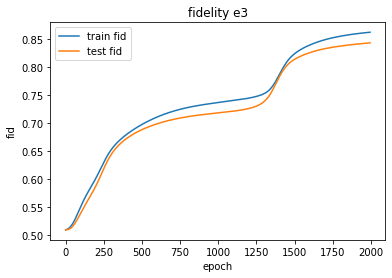

In [35]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")


plt.legend()
plt.title("fidelity e3",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.160502817004182


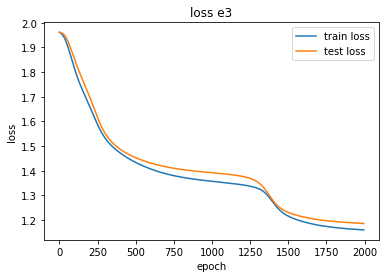

In [36]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("loss e3",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

In [32]:
name = "training_e3"

Circuit_prop={   "shots":shots, "nr_trash":nr_trash, "nr_latent":nr_latent, "nr_ent":nr_ent }
Training_param = { "num_samples" : num_samples,
                    "batch_size" : batch_size,
                    "nr_layers": nr_layers,
                    "epochs" :epochs,
                    "learning_rate" : learning_rate ,
                    "beta1" : beta1,
                    "beta2 ": beta2,
                     "optimizer":"Adam"}

performance={"loss_hist":loss_hist, "fid_hist":fid_hist,
             "loss_hist_test":loss_hist_test, "fid_hist_test":fid_hist_test,
             "encoder_params":encoder_params}

experiment_data={"Circuit_prop":Circuit_prop,
                "Training_param":Training_param,
                "performance:":performance,
                "Name":name}

# open file for writing
f = open(name+".txt","w")
f.write( str(experiment_data) )

65023